## Manuscript Plots

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.ticker as mtick

from tqdm import tnrange

In [2]:
import os
import sys
nb_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
from cvtk.plots import correction_diagnostic_plot

In [4]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.figsize'] = (6.0, 2.50)
mpl.rcParams['figure.dpi'] = 200

In [5]:
# image sizes
ONECOL = 3.42
THREEHALVESCOL = 4.5
TWOCOL = 7

## Barghi et al (2019) Combined Plots

In [6]:
barghi_gw_temp_covs_cis = np.load("../../data/barghi_et_al_2019/gw_temp_covs_cis.npy")
barghi_g_cis_averep = np.load("../../data/barghi_et_al_2019/g_cis_averep.npy")
barghi_g = np.load("../../data/barghi_et_al_2019/g.npy")

In [7]:
def cov_plot(cov_cis, ax=None, alpha=1, error_alpha=1, ngens=1, linewidth=1, ylim=None, xlim=None, hline=True, 
             cmap=cm.Dark2, y_multiplier=None, xticks=None, ylab=None):
    if ax is None:
        fig, ax = plt.subplots()
    _, T, T = cov_cis.shape
    y_multiplier = y_multiplier if y_multiplier is not None else 1
    mid_T = (T-4)/2
    for refgen in range(T):
        x = 2*ngens + np.arange(refgen, T) * ngens - mid_T + refgen*0.7  # TODO a bit of a hack
        mean = y_multiplier*cov_cis[1][refgen, (refgen+1):]
        lower, upper = y_multiplier*cov_cis[0][refgen, (refgen+1):]-mean, mean-y_multiplier*cov_cis[2][refgen, (refgen+1):]
        
        #ax.plot(np.broadcast_to(ngens*np.arange(refgen, T), (2, T-refgen)), temp_covs_bs[(0, 2), refgen, refgen:])
        ax.plot(x[:-1], mean, '-o', linewidth=linewidth, solid_capstyle='round', alpha=alpha, c=cmap(refgen), 
                label=refgen, zorder=refgen, markersize=3.5, markeredgecolor='w')
        ax.plot(x[:-1], mean, 'o', linewidth=linewidth, solid_capstyle='round', alpha=alpha, c=cmap(refgen), 
                label=refgen, zorder=refgen, markersize=4.3, markeredgecolor='w')
        ax.errorbar(x[:-1], mean, yerr=np.column_stack([lower.ravel(), upper.ravel()]).T, 
                    capsize=0, elinewidth=linewidth, c=cmap(refgen), 
                    linewidth=0,
                    zorder=100+refgen, alpha=error_alpha, label=None, solid_capstyle='round')

    if ylim is not None:
        plt.ylim(ylim)
    
    if xlim is not None:
        plt.xlim(xlim)
    #plt.xticks(np.arange(0, T*ngens, 10))
    if xticks is not None:
        plt.xticks(xticks)
    if hline:
        ax.axhline(y=0, c='0.6', linewidth=0.5, zorder=-1e6, linestyle='--')
    
    if ylab is None:
        ylab = "covariance"
        if y_multiplier is not None:
            ylab += f"  $(\\times 10^{{{int(np.log10(1/y_multiplier))}}})$"
        
#     ylab = "covariance "
#     if y_multiplier is not None:
#         ylab += "\n $\\mathrm{cov}(\\Delta p_s, \\Delta p_t)$"
#         ylab += f"  $ \\times 10^{{{int(np.log10(1/y_multiplier))}}}$"
#     add_latex = False
#     if add_latex:
#         ylab += "\n $\\mathrm{cov}(\\Delta p_s, \\Delta p_t)$"       
        
    ax.set_ylabel(ylab)
    #plt.legend(loc=(0.02, 0.75))

In [8]:
def G_plot(g, g_averep_cis=None, alpha=1, point_alpha=1, linewidth=1, ax=None, 
           ylim=None, xlim=None, as_percent=True, hline=True, cmap=None, ci_col='0.2',
           rep_markersize=0):
    if ax is None:
        fig, ax = plt.subplots()
    T, R = g.shape
    y_multiplier = 100. if as_percent else 1.
    x = np.arange(1, T+1) * 10
    cmap = cm.viridis if cmap is None else cmap
    cols = cmap(np.linspace(0, 1, T-1))
    for rep in range(R):
        for t in range(T-1):
            xa = x[t:(t+2)]
            mean = g[t:(t+2), rep]
            #import pdb; pdb.set_trace()
            ax.plot(xa, y_multiplier*mean, '-o', linewidth=linewidth, c=cols[t],
                    alpha=alpha, zorder=-t, markersize=rep_markersize, solid_capstyle='round',  markeredgecolor='w')
            ax.plot(xa, y_multiplier*mean, 'o', linewidth=linewidth, c=cols[t],
                    alpha=point_alpha, zorder=-t, markersize=rep_markersize, solid_capstyle='round',  markeredgecolor='w')
            
    if g_averep_cis is not None:
        mean = g_averep_cis[1, :]
        lower, upper = g_averep_cis[0, :]-mean, mean-g_averep_cis[2, :]
        ax.plot(x, y_multiplier*mean, '-o', linewidth=linewidth, c=ci_col, markerfacecolor='w',
                zorder=1e4, markersize=2, markeredgecolor='w', markeredgewidth=3)
        ax.errorbar(x, y_multiplier*mean, yerr=y_multiplier*np.column_stack([lower.ravel(), upper.ravel()]).T, 
                     capsize=0, elinewidth=linewidth*1.3, linewidth=0,
                     zorder=1e5, alpha=1, c=ci_col, label=None, solid_capstyle='round')
        ax.plot(x, y_multiplier*mean, 'o', linewidth=linewidth, c='k',
               zorder=np.Inf, markersize=2.1)
        

    if ylim is not None:
        plt.ylim(ylim)
    
    if xlim is not None:
        plt.xlim(xlim)
    if hline:
        ax.axhline(y=0, c='0.6', linewidth=0.5, zorder=-100, linestyle='--')

    ax.set_xlabel("generation ($t$)")
    ax.set_ylabel("$G(t)$")

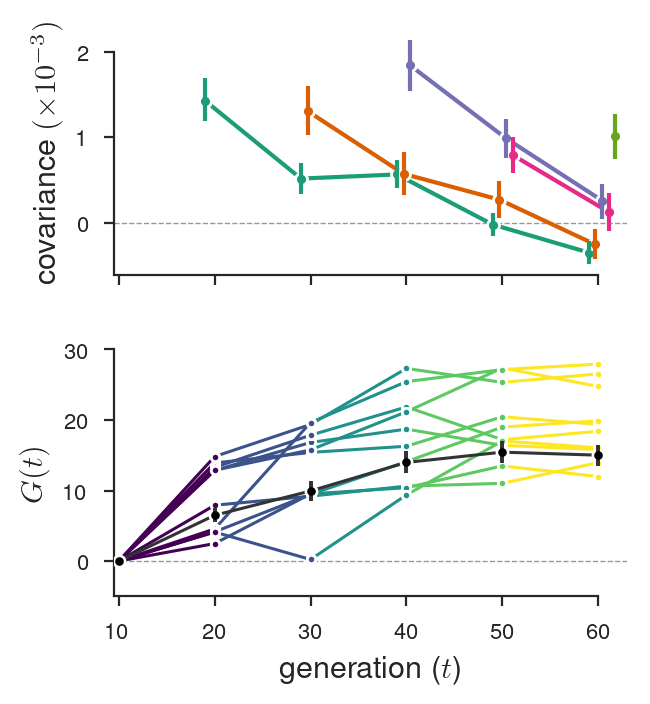

In [9]:
#plt.rc('text', usetex=False)
plt.rc('text', usetex=True)
plt.style.use('./buffalo.mplstyle')

fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(ONECOL*1.5, ONECOL*1.1))

cov_plot(barghi_gw_temp_covs_cis, ax=ax[0], ngens=10, xlim=(9.5, 63), y_multiplier=1000, 
         linewidth=1.5, xticks=np.arange(0, 63, 10))
G_plot(barghi_g, barghi_g_cis_averep, ax=ax[1], xlim=(9.5, 63), ylim=(-5, 30),
       linewidth=1.1, alpha=1, rep_markersize=3)


# customize plots
#ax[0].spines['bottom'].set_bounds(10, 60)
#ax[0].spines['bottom'].set_bounds(9.7, 60)
#ax[0].spines['left'].set_bounds(-0.6, 2)
#ax[0].spines['left'].set_bounds(0, 2)  # end top y axis at 0
# this drops top y axis below 0
#ax[1].spines['left'].set_position(('axes', -0.01))
# this combines the top y axis with the x axis
#ax[0].spines['left'].set_position(('axes', 0.01))
#ax[0].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
#ax[0].yaxis.set_major_formatter(mtick.LogFormatterMathtext())

#ax[1].yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f"${int(x)}\\%$"))

# uncomment if you don't want latex tick labels
ax[1].yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f"{int(x)}%"))
# ax[1].xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f"{x}"))
ax[1].xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f"{x}"))
ax[0].yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f"{int(x)}"))

ax[0].spines['bottom'].set_bounds(9.5, 60)
ax[1].spines['bottom'].set_bounds(9.5, 60)
ax[0].spines['left'].set_bounds(-0.6, 2)
ax[1].spines['left'].set_bounds(-5, 30)
#ax[1].spines['left'].set_bounds(-3, 20)
#ax[1].spines['left'].set_bounds(0, 20)

plt.subplots_adjust(wspace=0.3, hspace=0.3, left=.4)
fig.savefig("figure-1-G-covs.pdf", bbox_inches='tight')

## Castro et al (2019)

In [10]:
castro_covs_cis = np.load("../../data/castro_et_al_2019/castro_et_al_2019_covs_bootstrap.npy")

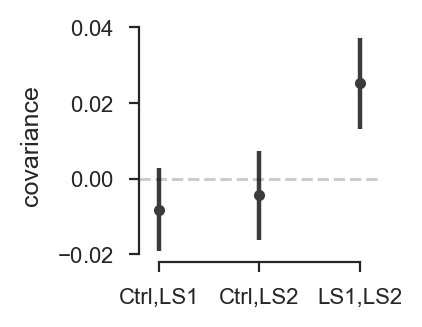

In [11]:
plt.style.use('buffalo.mplstyle')
plt.rc('text', usetex=False)

mean = castro_covs_cis[1]
mpl.rcParams['figure.figsize'] = (ONECOL/2.2, ONECOL/2.2)
#plt.figure(figsize=(5, 5))
lower, upper = castro_covs_cis[0]-mean, mean-castro_covs_cis[2]
#comps = [('cov($\Delta p_\mathrm{Ctrl}, \Delta p_\mathrm{LS1}$)', 0, 1), ('cov($\Delta p_\mathrm{Ctrl}, \Delta p_\mathrm{LS2}$)', 0, 2), ('cov($\Delta p_\mathrm{LS1}, \Delta p_\mathrm{LS2}$)', 1, 2)]
comps = [('Ctrl,LS1', 0, 1), 
         ('Ctrl,LS2', 0, 2), 
         ('LS1,LS2', 1, 2)]
means = [mean[r, c] for _, r, c in comps]
bounds = np.stack([(lower[r, c], upper[r, c]) for _, r, c in comps]).T
labels = [l for l, _, _ in comps]
  
ax = plt.subplot()    
ax.errorbar(labels, means, yerr=bounds, capsize=0, fmt='o', linewidth=2, elinewidth=1.6, markersize=3, c='0.23')
ax.axhline(y=0, c='k', alpha=0.2, linestyle='--')

ax.spines['left'].set_bounds(-0.02, 0.04)
ax.spines['bottom'].set_bounds(0, 2)
#ax.tick_params(axis='both', which='major', labelsize=10)
plt.ylabel('covariance', fontsize=9) #, fontsize=13)
ax.set_xlim(-0.2, 2.2)
#plt.xlabel('comparison')
#ax.set_xticklabels(labels, rotation = 45, ha="right")
plt.savefig('castro_rep_cis.pdf', bbox_inches="tight")


## Kelly and Hughes (2019)

In [12]:
kh_covs_cis = np.load("../../data/kelly_hughes_2019/kelly_hughes_2019_covs_bootstrap.npy")

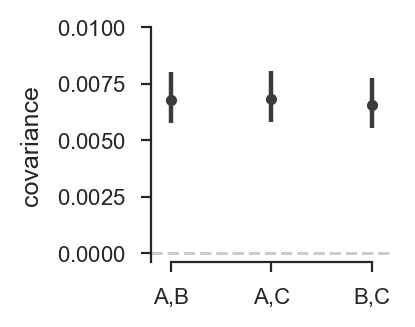

In [13]:
plt.style.use('buffalo.mplstyle')
plt.rc('text', usetex=False)

mean = kh_covs_cis[1]
mpl.rcParams['figure.figsize'] = (ONECOL/2.2, ONECOL/2.2)
#plt.figure(figsize=(5, 5))
lower, upper = kh_covs_cis[0]-mean, mean-kh_covs_cis[2]
comps = [('A,B', 0, 1), 
         ('A,C', 0, 2), 
         ('B,C', 1, 2)]
means = [mean[r, c] for _, r, c in comps]
bounds = np.stack([(lower[r, c], upper[r, c]) for _, r, c in comps]).T
labels = [l for l, _, _ in comps]
  
ax = plt.subplot()
ax.errorbar(labels, means, yerr=bounds, capsize=0, fmt='o', linewidth=2, elinewidth=1.6, markersize=3, c='0.23')
ax.axhline(y=0, c='k', alpha=0.2, linestyle='--')


#ax.spines['left'].set_bounds(-0.02, 0.04)
ax.spines['bottom'].set_bounds(-0, 2)
ax.spines['left'].set_bounds(-0.0004, 0.01)
#ax.tick_params(axis='both', which='major', labelsize=10)
#plt.ylabel('covariance', fontsize=13)
ax.set_ylim(-0.0004, 0.01)
ax.set_xlim(-0.2, 2.2)
plt.ylabel('covariance', fontsize=9)
#plt.xlabel('comparison')
#ax.set_xticklabels(labels, rotation = 45, ha="right")
#plt.savefig('castro_rep_cis.pdf', bbox_inches="tight")
plt.savefig('kh_rep_cis.pdf', bbox_inches="tight")



### Barghi Convergence Correlation Plot

In [14]:
barghi_conv_corr_cis = np.load("../../data/barghi_et_al_2019/barghi_et_al_2019_conv_corr_cis.npy")[:, 0, ...]

In [15]:
def convcorr_plot(cov_cis, ax=None, alpha=1, error_alpha=1, ngens=1, linewidth=1, ylim=None, xlim=None, hline=True, 
             cmap=cm.Dark2, y_multiplier=None, xticks=None, ylab=None):
    if ax is None:
        fig, ax = plt.subplots()
    _, T, T = cov_cis.shape
    y_multiplier = y_multiplier if y_multiplier is not None else 1
    mid_T = (T-4)/2
    for refgen in range(T):
        x = ngens + np.arange(refgen, T) * ngens - mid_T + refgen*0.7  # TODO a bit of a hack
        mean = y_multiplier*cov_cis[1][refgen, refgen:]
        lower, upper = y_multiplier*cov_cis[0][refgen, refgen:]-mean, mean-y_multiplier*cov_cis[2][refgen, refgen:]
        
        #ax.plot(np.broadcast_to(ngens*np.arange(refgen, T), (2, T-refgen)), temp_covs_bs[(0, 2), refgen, refgen:])
        ax.plot(x, mean, '-o', linewidth=linewidth, solid_capstyle='round', alpha=alpha, c=cmap(refgen), 
                label=refgen, zorder=refgen, markersize=3., markeredgecolor='w')
        ax.plot(x, mean, 'o', linewidth=linewidth, solid_capstyle='round', alpha=alpha, c=cmap(refgen), 
                label=refgen, zorder=refgen, markersize=3.5, markeredgecolor='w')
        ax.errorbar(x, mean, yerr=np.column_stack([lower.ravel(), upper.ravel()]).T, 
                    capsize=0, elinewidth=linewidth, c=cmap(refgen), 
                    linewidth=0,
                    zorder=100+refgen, alpha=error_alpha, label=None, solid_capstyle='round')

    if ylim is not None:
        plt.ylim(ylim)
    
    if xlim is not None:
        plt.xlim(xlim)
    #plt.xticks(np.arange(0, T*ngens, 10))
    if xticks is not None:
        plt.xticks(xticks)
    if hline:
        ax.axhline(y=0, c='0.6', linewidth=0.5, zorder=-1e6, linestyle='--')
    
    if ylab is None:
        ylab = "covariance"
        if y_multiplier is not None:
            ylab += f"  $(\\times 10^{{{int(np.log10(1/y_multiplier))}}})$"
        
#     ylab = "covariance "
#     if y_multiplier is not None:
#         ylab += "\n $\\mathrm{cov}(\\Delta p_s, \\Delta p_t)$"
#         ylab += f"  $ \\times 10^{{{int(np.log10(1/y_multiplier))}}}$"
#     add_latex = False
#     if add_latex:
#         ylab += "\n $\\mathrm{cov}(\\Delta p_s, \\Delta p_t)$"       
        
    ax.set_ylabel(ylab)
    #plt.legend(loc=(0.02, 0.75))

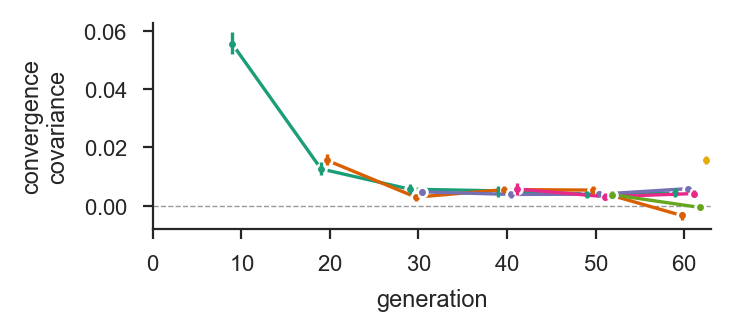

In [16]:
fig, ax = plt.subplots(ncols=1, nrows=1, sharex=True, figsize=(THREEHALVESCOL*0.8, ONECOL/2.5))

convcorr_plot(barghi_conv_corr_cis, ax=ax, ngens=10, xlim=(9.5, 63), y_multiplier=None, linewidth=1.2,
              xticks=np.arange(0, 63, 10), ylab='convergence\ncorrelation')

ax.set_xlabel("generation", fontsize=8.5)
ax.set_ylabel("convergence\ncovariance", fontsize=8.5)


#ax.spines['left'].set_bounds(-0.018, 0.1)
#ax.spines['bottom'].set_bounds(0, 60)
fig.savefig("figure-2-corr.pdf", bbox_inches='tight')

## Empirical Null

In [17]:
barghi_emp_null_tile = np.load('../../data/barghi_et_al_2019/empnull_tile.npy')
barghi_emp_null_seqid = np.load('../../data/barghi_et_al_2019/empnull_seqid_1e6.npy')
barghi_tile_covs = np.load('../../data/barghi_et_al_2019/tile_temporal_covs_1e6.npy')

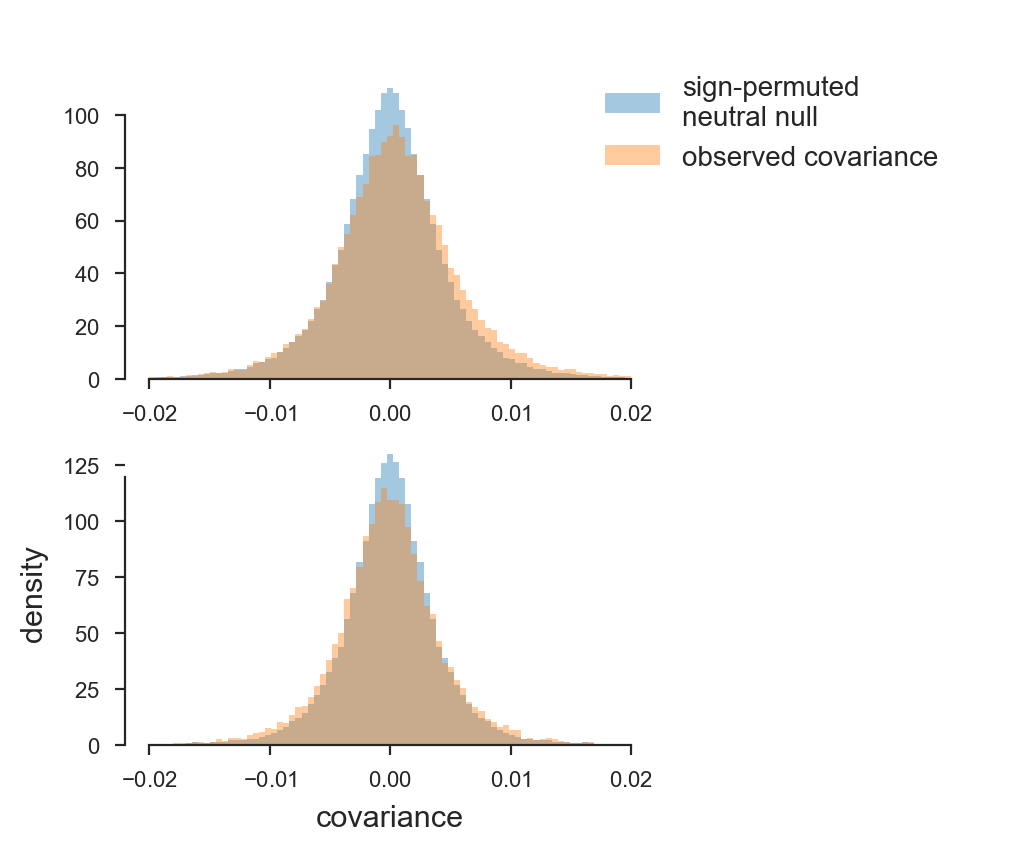

In [18]:
def cov_hist(empnull, real, rep=None, k=2, bins=np.linspace(-0.03, 0.03, 50), alpha=0.4,
             ax=None, 
             empnull_label='sign-permuted\nneutral null', real_label='observed covariance',
             xlabel='covariance', ylabel='density'):
    assert(empnull.ndim == 5)
    rep = slice(None) if rep is None else rep
    # empnull is npermutations x nblocks x T x T x R
    # real is nblocks x T x T x R
    # after extracting diagonal, empnull_covs is npermutations x nblocks x R x U where U is elements
    # among diagonal k
    empnull_covs = np.diagonal(empnull, offset=k, axis1=2, axis2=3)[:, :, rep, :].ravel()
    real_covs = np.diagonal(real, offset=k, axis1=1, axis2=2)[:, rep, :].ravel()
    if ax is None:
        fig, ax = plt.subplots()
    ax.hist(empnull_covs, bins, alpha=alpha, density=True, label=empnull_label)
    ax.hist(real_covs, bins, alpha=alpha, density=True, label=real_label)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    return ax

fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(ONECOL, 1.3*ONECOL))
cov_hist(barghi_emp_null_tile, barghi_tile_covs, k=2, rep=None, ax=ax[0], bins=np.linspace(-0.02, 0.02, 80))
cov_hist(barghi_emp_null_tile, barghi_tile_covs, k=4, rep=None, ax=ax[1], bins=np.linspace(-0.02, 0.02, 80))
ax[0].legend(loc=(0.8,0.5))

ax[0].spines['left'].set_bounds(0, 100)
ax[1].spines['left'].set_bounds(0, 120)
ax[0].spines['bottom'].set_bounds(-0.02, 0.02)
ax[1].spines['bottom'].set_bounds(-0.02, 0.02)
fig.savefig("figure-3-hists.pdf", bbox_inches='tight')
#ax[0].text(-0.02, 220, "permuted seqid blocks")
#ax[1].text(-0.02, 240, "permuted tile blocks")

### P-value calculation

This pools all replicates.

In [ ]:

def tail_probs(empnull, real, k=3, alpha=0.01):
    emp = np.diagonal(empnull, offset=k, axis1=2, axis2=3)
    emp = emp[np.isfinite(emp)]
    tails = np.quantile(emp, (alpha, 1-alpha))
    lt, rt = np.mean(real < tails[0]), np.mean(real > tails[1])
    return lt, rt

def bootstrap_tail_probs(empnull, real, B=1000, alpha=0.01, progress_bar=False):
    nperms, nblocks, T, T_, R = empnull.shape
    straps = []
    B_range = tnrange(B) if progress_bar else np.arange(B)
    real_ks = {k: np.diagonal(real, offset=k, axis1=1, axis2=2) for k in np.arange(1, T)}
    real_ks = {k: v[np.isfinite(v)] for k, v in real_ks.items()}
    for b in B_range:
        bidx = np.random.randint(0, nblocks, size=nblocks)
        bootstrap_empnull = empnull[:, bidx, :, :, :]
        #import pdb; pdb.set_trace()
        straps.append([tail_probs(bootstrap_empnull, real_ks[k], k=k, alpha=alpha) for k in np.arange(1, T)])
    return straps
        
#[(k, empnull_pvalue(barghi_emp_null_tile, barghi_tile_covs, k=k, alpha=0.1)) for k in np.arange(2, 6)]

a = bootstrap_tail_probs(barghi_emp_null_tile, barghi_tile_covs, B=1000, progress_bar=True)


    

In [31]:
a

[[(0.0006690777576853526, 0.0019710669077757687),
  (0.010081374321880651, 0.019145569620253166),
  (0.011422543701024714, 0.01805304400241109),
  (0.015325497287522603, 0.014014466546112115),
  (0.017540687160940326, 0.010759493670886076)]]

In [531]:
np.array(a)[:, 1, :]

array([[0.99787523, 0.        ],
       [0.99785262, 0.        ],
       [0.9977396 , 0.        ],
       ...,
       [0.99801085, 0.        ],
       [0.99787523, 0.        ],
       [0.99776221, 0.        ]])

No handles with labels found to put in legend.
No handles with labels found to put in legend.


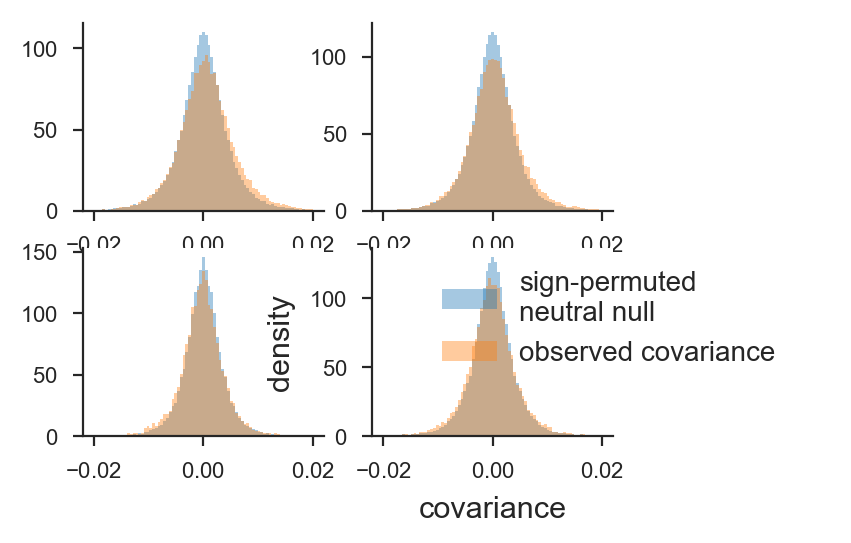

In [378]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(ONECOL, ONECOL*0.
cov_hist(barghi_emp_null_tile, barghi_tile_covs, k=2, rep=None, ax=ax[0, 0], bins=np.linspace(-0.02, 0.02, 80))
cov_hist(barghi_emp_null_tile, barghi_tile_covs, k=3, rep=None, ax=ax[0, 1], bins=np.linspace(-0.02, 0.02, 80))
cov_hist(barghi_emp_null_tile, barghi_tile_covs, k=4, rep=None, ax=ax[1, 1], bins=np.linspace(-0.02, 0.02, 80))
cov_hist(barghi_emp_null_tile, barghi_tile_covs, k=5, rep=None, ax=ax[1, 0], bins=np.linspace(-0.02, 0.02, 80))
#ax[0].text(-0.02, 220, "permuted seqid blocks")
#ax[1].text(-0.02, 240, "permuted tile blocks")

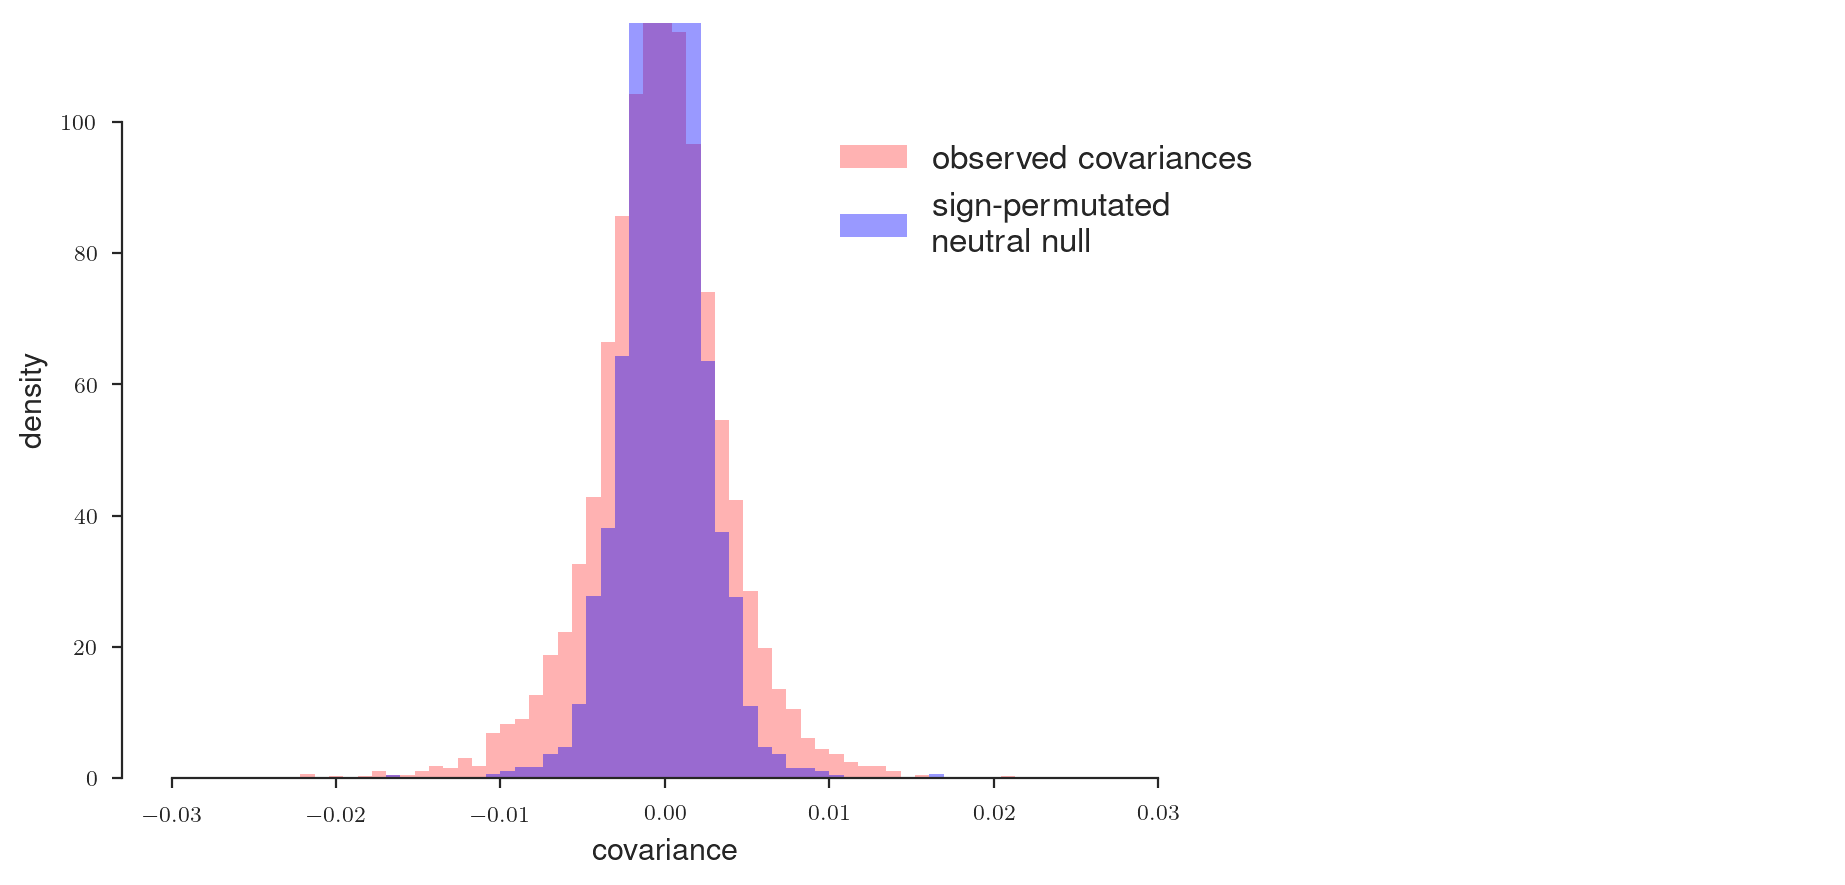

In [279]:
from cvtk.cov import stack_temporal_covariances

bins = np.linspace(-0.03, 0.03, 70)
covs = barghi_tile_covs
empcov_tile_stacked = barghi_emp_null
# empirical null
k = 5
empnull_k2 = list()
R, T = 10, 6
for row in range(0, T-k):
    empnull_k2.append(empcov_tile_stacked[:, :, row, row+k, :].ravel())
    
real_covs_diag_k2 = np.diagonal(covs, k, axis1=1, axis2=2).ravel()


fig, ax = plt.subplots(figsize=(7, 5))
#ax.hist(real_covs_diag_k2, bins, alpha=0.3, density=True, label='observed covariances\ncov($\Delta p_t, \Delta p_{t+%s}$)' % k, color=darj1[0])
ax.hist(real_covs_diag_k2, bins, alpha=0.3, density=True, label='observed covariances', color='r')

ax.hist(np.stack(empnull_k2).ravel(), bins, alpha=0.4, density=True, label='sign-permutated\nneutral null', color='b')
ax.spines['bottom'].set_bounds(-0.03, 0.03)
ax.spines['left'].set_bounds(0, 100)
plt.ylim(0, 115)
plt.ylabel('density')
plt.xlabel('covariance')
ax.legend(loc=(0.6, 0.6), mode='expand', fontsize=12)
plt.show()

# Supplementary Plots

In [311]:
with open('../../data/barghi_et_al_2019/diagonistics_tuple.pkl', 'rb') as f:
    barghi_diagonistics = pickle.load(f)


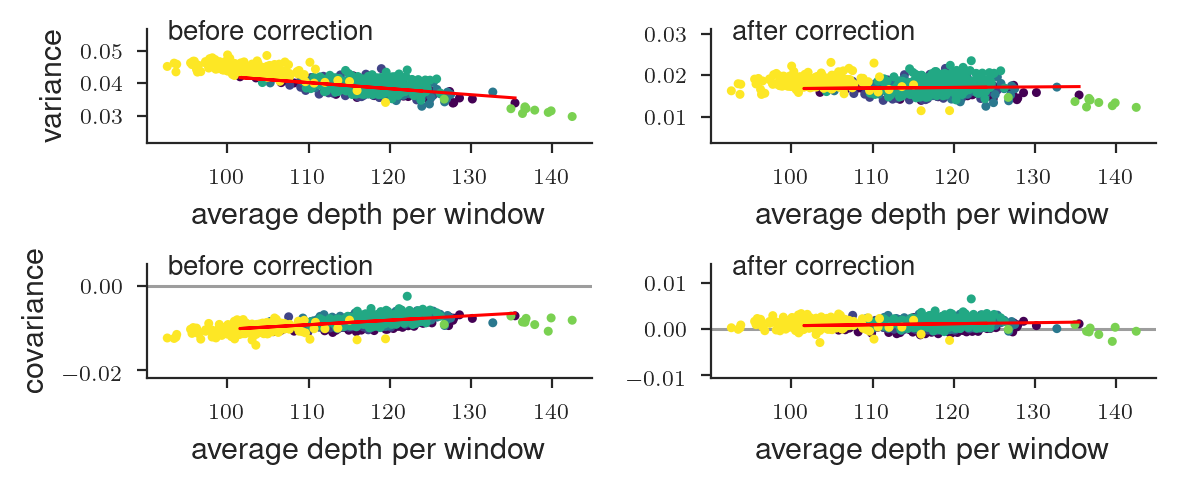

In [313]:
_ = correction_diagnostic_plot(barghi_diagonistics)

# Old Stuff

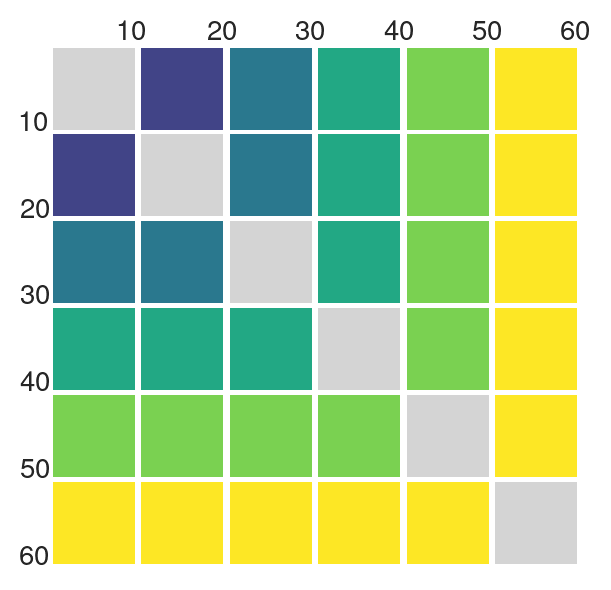

In [111]:
def make_grid(T):
    M = np.zeros((T, T))
    rows, cols = np.indices((T, T))
    for t in np.arange(T)[::-1]:
        M[(cols <= t) & (rows <= t)] = t
    np.fill_diagonal(M, np.nan)
    return M

#plt.imshow(make_grid(T))

# import matplotlib.gridspec as gridspec
# gs = gridspec.GridSpec(T, T)
# gs.update(wspace=0.01, hspace=0.04)

T = 6

fig, ax = plt.subplots(nrows=T, ncols=T, figsize=(ONECOL, ONECOL))
M = np.zeros((T, T))
rows, cols = np.indices((T, T))
bg_cols = cm.viridis(np.linspace(0, 1, T))

for t in np.arange(T)[::-1]:
    for r in np.arange(t):
        ax[r,t].set_facecolor(bg_cols[t])
        ax[t,r].set_facecolor(bg_cols[t])
    for r in np.arange(T):
        if r == t:
            ax[t,r].set_facecolor('44')
        ax[t, r].set_aspect('equal')
        ax[r, t].set_aspect('equal')
        
        ax[t, r].get_xaxis().set_visible(False)
        ax[r, t].get_xaxis().set_visible(False)
        ax[t, r].get_yaxis().set_visible(False)
        ax[t, r].get_yaxis().set_visible(False)
        
        ax[t, r].spines['top'].set_visible(False)
        ax[t, r].spines['right'].set_visible(False)
        ax[t, r].spines['left'].set_visible(False)
        ax[t, r].spines['bottom'].set_visible(False)
        if r == 0:
            ax[r, t].text(0.8, 1.1, (t+1)*10)
        if t == 0:
            ax[r, t].text(-0.4, 0, (r+1)*10)
plt.subplots_adjust(wspace=0.01, hspace=0.06)